In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, glossQ, dlossQ, _ = sess.run([model.d_loss, model.g_lossQ, model.d_lossQ, 
                                                 model.d_opt], #, model.d_optQ
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 gloss:1.3773 dloss:2.0290 glossQ:1.0049 dlossQ:1.4560 exploreP:0.9986
Episode:1 meanR:20.0000 R:26.0000 rate:0.0520 gloss:1.3761 dloss:2.0240 glossQ:1.0070 dlossQ:1.4783 exploreP:0.9960
Episode:2 meanR:26.6667 R:40.0000 rate:0.0800 gloss:1.3734 dloss:2.0108 glossQ:1.0080 dlossQ:1.4470 exploreP:0.9921
Episode:3 meanR:24.0000 R:16.0000 rate:0.0320 gloss:1.3694 dloss:1.9894 glossQ:1.0130 dlossQ:1.4114 exploreP:0.9905
Episode:4 meanR:25.4000 R:31.0000 rate:0.0620 gloss:1.3688 dloss:1.9948 glossQ:1.0105 dlossQ:1.4694 exploreP:0.9875
Episode:5 meanR:23.1667 R:12.0000 rate:0.0240 gloss:1.3667 dloss:1.9856 glossQ:1.0092 dlossQ:1.4783 exploreP:0.9863
Episode:6 meanR:22.0000 R:15.0000 rate:0.0300 gloss:1.3654 dloss:1.9845 glossQ:1.0099 dlossQ:1.5087 exploreP:0.9849
Episode:7 meanR:21.0000 R:14.0000 rate:0.0280 gloss:1.3656 dloss:1.9802 glossQ:1.0116 dlossQ:1.4943 exploreP:0.9835
Episode:8 meanR:20.1111 R:13.0000 rate:0.0260 gloss:1.3629 dloss:1.9619 

Episode:71 meanR:22.6250 R:11.0000 rate:0.0220 gloss:1.2489 dloss:1.5575 glossQ:1.1235 dlossQ:1.3132 exploreP:0.8512
Episode:72 meanR:22.8219 R:37.0000 rate:0.0740 gloss:1.2566 dloss:1.5796 glossQ:1.1544 dlossQ:1.3927 exploreP:0.8481
Episode:73 meanR:22.8514 R:25.0000 rate:0.0500 gloss:1.2557 dloss:1.5686 glossQ:1.1127 dlossQ:1.2763 exploreP:0.8460
Episode:74 meanR:22.7333 R:14.0000 rate:0.0280 gloss:1.2463 dloss:1.5476 glossQ:1.1035 dlossQ:1.2649 exploreP:0.8448
Episode:75 meanR:22.6711 R:18.0000 rate:0.0360 gloss:1.2434 dloss:1.5453 glossQ:1.1188 dlossQ:1.2748 exploreP:0.8433
Episode:76 meanR:22.5844 R:16.0000 rate:0.0320 gloss:1.2537 dloss:1.5504 glossQ:1.1166 dlossQ:1.2574 exploreP:0.8420
Episode:77 meanR:23.0641 R:60.0000 rate:0.1200 gloss:1.2380 dloss:1.5274 glossQ:1.1484 dlossQ:1.2861 exploreP:0.8370
Episode:78 meanR:23.0886 R:25.0000 rate:0.0500 gloss:1.2328 dloss:1.5179 glossQ:1.1470 dlossQ:1.2621 exploreP:0.8349
Episode:79 meanR:23.1000 R:24.0000 rate:0.0480 gloss:1.2329 dlos

Episode:141 meanR:20.4000 R:21.0000 rate:0.0420 gloss:1.1461 dloss:1.3470 glossQ:1.1517 dlossQ:1.2588 exploreP:0.7450
Episode:142 meanR:20.3400 R:12.0000 rate:0.0240 gloss:1.1920 dloss:1.3930 glossQ:1.1216 dlossQ:1.2125 exploreP:0.7441
Episode:143 meanR:20.1200 R:16.0000 rate:0.0320 gloss:1.1644 dloss:1.3658 glossQ:1.1445 dlossQ:1.2501 exploreP:0.7429
Episode:144 meanR:20.1500 R:18.0000 rate:0.0360 gloss:1.1750 dloss:1.3844 glossQ:1.2592 dlossQ:1.3948 exploreP:0.7416
Episode:145 meanR:20.1300 R:9.0000 rate:0.0180 gloss:1.1338 dloss:1.3344 glossQ:1.1735 dlossQ:1.3110 exploreP:0.7409
Episode:146 meanR:19.8800 R:13.0000 rate:0.0260 gloss:1.1509 dloss:1.3509 glossQ:1.1427 dlossQ:1.2438 exploreP:0.7400
Episode:147 meanR:20.2000 R:50.0000 rate:0.1000 gloss:1.1608 dloss:1.3620 glossQ:1.1372 dlossQ:1.2568 exploreP:0.7363
Episode:148 meanR:19.6500 R:15.0000 rate:0.0300 gloss:1.1886 dloss:1.3912 glossQ:1.1405 dlossQ:1.2522 exploreP:0.7352
Episode:149 meanR:19.5800 R:11.0000 rate:0.0220 gloss:1.1

Episode:211 meanR:14.8500 R:13.0000 rate:0.0260 gloss:1.1143 dloss:1.2876 glossQ:1.1795 dlossQ:1.1887 exploreP:0.6724
Episode:212 meanR:14.8600 R:13.0000 rate:0.0260 gloss:1.1469 dloss:1.3226 glossQ:1.1259 dlossQ:1.1307 exploreP:0.6716
Episode:213 meanR:14.8600 R:10.0000 rate:0.0200 gloss:1.1299 dloss:1.3037 glossQ:1.1369 dlossQ:1.1447 exploreP:0.6709
Episode:214 meanR:14.8500 R:11.0000 rate:0.0220 gloss:1.1419 dloss:1.3147 glossQ:1.1426 dlossQ:1.1450 exploreP:0.6702
Episode:215 meanR:14.8600 R:10.0000 rate:0.0200 gloss:1.1288 dloss:1.3050 glossQ:1.1480 dlossQ:1.1590 exploreP:0.6695
Episode:216 meanR:14.8500 R:12.0000 rate:0.0240 gloss:1.1255 dloss:1.2975 glossQ:1.1689 dlossQ:1.1771 exploreP:0.6687
Episode:217 meanR:14.8500 R:11.0000 rate:0.0220 gloss:1.1536 dloss:1.3266 glossQ:1.1450 dlossQ:1.1532 exploreP:0.6680
Episode:218 meanR:14.7900 R:9.0000 rate:0.0180 gloss:1.1510 dloss:1.3246 glossQ:1.1560 dlossQ:1.1633 exploreP:0.6674
Episode:219 meanR:14.8000 R:14.0000 rate:0.0280 gloss:1.1

Episode:281 meanR:13.6700 R:11.0000 rate:0.0220 gloss:1.1439 dloss:1.3186 glossQ:1.1386 dlossQ:1.1455 exploreP:0.6121
Episode:282 meanR:13.6800 R:12.0000 rate:0.0240 gloss:1.1510 dloss:1.3257 glossQ:1.1281 dlossQ:1.1342 exploreP:0.6114
Episode:283 meanR:13.6400 R:11.0000 rate:0.0220 gloss:1.1498 dloss:1.3282 glossQ:1.1350 dlossQ:1.1516 exploreP:0.6108
Episode:284 meanR:13.6600 R:12.0000 rate:0.0240 gloss:1.1488 dloss:1.3240 glossQ:1.1401 dlossQ:1.1462 exploreP:0.6100
Episode:285 meanR:13.6800 R:13.0000 rate:0.0260 gloss:1.1330 dloss:1.3066 glossQ:1.1445 dlossQ:1.1502 exploreP:0.6093
Episode:286 meanR:13.7100 R:15.0000 rate:0.0300 gloss:1.1439 dloss:1.3193 glossQ:1.1406 dlossQ:1.1512 exploreP:0.6084
Episode:287 meanR:13.6400 R:11.0000 rate:0.0220 gloss:1.1578 dloss:1.3332 glossQ:1.1396 dlossQ:1.1470 exploreP:0.6077
Episode:288 meanR:13.7100 R:18.0000 rate:0.0360 gloss:1.1602 dloss:1.3366 glossQ:1.1308 dlossQ:1.1384 exploreP:0.6066
Episode:289 meanR:13.7800 R:19.0000 rate:0.0380 gloss:1.

Episode:351 meanR:13.3400 R:12.0000 rate:0.0240 gloss:1.1379 dloss:1.3119 glossQ:1.1360 dlossQ:1.1403 exploreP:0.5596
Episode:352 meanR:13.2600 R:9.0000 rate:0.0180 gloss:1.1324 dloss:1.3035 glossQ:1.1412 dlossQ:1.1433 exploreP:0.5591
Episode:353 meanR:13.2700 R:17.0000 rate:0.0340 gloss:1.1350 dloss:1.3068 glossQ:1.1344 dlossQ:1.1367 exploreP:0.5581
Episode:354 meanR:13.2500 R:10.0000 rate:0.0200 gloss:1.1157 dloss:1.2878 glossQ:1.1693 dlossQ:1.1763 exploreP:0.5576
Episode:355 meanR:13.2700 R:17.0000 rate:0.0340 gloss:1.1414 dloss:1.3129 glossQ:1.1260 dlossQ:1.1283 exploreP:0.5566
Episode:356 meanR:13.3500 R:16.0000 rate:0.0320 gloss:1.1228 dloss:1.2949 glossQ:1.1512 dlossQ:1.1582 exploreP:0.5558
Episode:357 meanR:13.3600 R:13.0000 rate:0.0260 gloss:1.1029 dloss:1.2731 glossQ:1.1447 dlossQ:1.1491 exploreP:0.5551
Episode:358 meanR:13.4000 R:13.0000 rate:0.0260 gloss:1.1203 dloss:1.2891 glossQ:1.1477 dlossQ:1.1493 exploreP:0.5544
Episode:359 meanR:13.3900 R:13.0000 rate:0.0260 gloss:1.1

Episode:421 meanR:12.4400 R:11.0000 rate:0.0220 gloss:1.1532 dloss:1.3274 glossQ:1.1251 dlossQ:1.1248 exploreP:0.5146
Episode:422 meanR:12.4600 R:11.0000 rate:0.0220 gloss:1.1432 dloss:1.3178 glossQ:1.1311 dlossQ:1.1377 exploreP:0.5141
Episode:423 meanR:12.5000 R:14.0000 rate:0.0280 gloss:1.1676 dloss:1.3425 glossQ:1.1023 dlossQ:1.1034 exploreP:0.5134
Episode:424 meanR:12.3500 R:8.0000 rate:0.0160 gloss:1.1388 dloss:1.3128 glossQ:1.1553 dlossQ:1.1556 exploreP:0.5130
Episode:425 meanR:12.3400 R:11.0000 rate:0.0220 gloss:1.1277 dloss:1.3029 glossQ:1.1468 dlossQ:1.1512 exploreP:0.5124
Episode:426 meanR:12.2600 R:8.0000 rate:0.0160 gloss:1.1637 dloss:1.3369 glossQ:1.1163 dlossQ:1.1163 exploreP:0.5120
Episode:427 meanR:12.3400 R:17.0000 rate:0.0340 gloss:1.1481 dloss:1.3244 glossQ:1.1681 dlossQ:1.1703 exploreP:0.5111
Episode:428 meanR:12.2800 R:11.0000 rate:0.0220 gloss:1.1497 dloss:1.3239 glossQ:1.1284 dlossQ:1.1286 exploreP:0.5106
Episode:429 meanR:12.2800 R:11.0000 rate:0.0220 gloss:1.13

Episode:491 meanR:12.2200 R:10.0000 rate:0.0200 gloss:1.1166 dloss:1.2897 glossQ:1.1416 dlossQ:1.1422 exploreP:0.4732
Episode:492 meanR:12.2200 R:11.0000 rate:0.0220 gloss:1.1205 dloss:1.2928 glossQ:1.1546 dlossQ:1.1560 exploreP:0.4727
Episode:493 meanR:12.1600 R:9.0000 rate:0.0180 gloss:1.1367 dloss:1.3070 glossQ:1.1603 dlossQ:1.1606 exploreP:0.4722
Episode:494 meanR:12.1800 R:10.0000 rate:0.0200 gloss:1.1388 dloss:1.3089 glossQ:1.1392 dlossQ:1.1390 exploreP:0.4718
Episode:495 meanR:12.1100 R:12.0000 rate:0.0240 gloss:1.1295 dloss:1.3005 glossQ:1.1581 dlossQ:1.1609 exploreP:0.4712
Episode:496 meanR:12.0700 R:9.0000 rate:0.0180 gloss:1.1177 dloss:1.2878 glossQ:1.1502 dlossQ:1.1523 exploreP:0.4708
Episode:497 meanR:12.0800 R:11.0000 rate:0.0220 gloss:1.1449 dloss:1.3154 glossQ:1.1925 dlossQ:1.1923 exploreP:0.4703
Episode:498 meanR:11.9700 R:9.0000 rate:0.0180 gloss:1.1175 dloss:1.2876 glossQ:1.1417 dlossQ:1.1413 exploreP:0.4699
Episode:499 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.144

Episode:561 meanR:12.0300 R:10.0000 rate:0.0200 gloss:1.1420 dloss:1.3164 glossQ:1.1290 dlossQ:1.1338 exploreP:0.4362
Episode:562 meanR:12.0700 R:12.0000 rate:0.0240 gloss:1.1423 dloss:1.3172 glossQ:1.1359 dlossQ:1.1442 exploreP:0.4356
Episode:563 meanR:11.9500 R:9.0000 rate:0.0180 gloss:1.1750 dloss:1.3488 glossQ:1.1111 dlossQ:1.1164 exploreP:0.4353
Episode:564 meanR:11.9700 R:13.0000 rate:0.0260 gloss:1.1462 dloss:1.3243 glossQ:1.1316 dlossQ:1.1422 exploreP:0.4347
Episode:565 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.1636 dloss:1.3409 glossQ:1.1376 dlossQ:1.1463 exploreP:0.4342
Episode:566 meanR:11.9700 R:13.0000 rate:0.0260 gloss:1.1433 dloss:1.3193 glossQ:1.1318 dlossQ:1.1422 exploreP:0.4337
Episode:567 meanR:11.9600 R:11.0000 rate:0.0220 gloss:1.1699 dloss:1.3487 glossQ:1.1144 dlossQ:1.1217 exploreP:0.4332
Episode:568 meanR:11.8800 R:9.0000 rate:0.0180 gloss:1.1603 dloss:1.3345 glossQ:1.1162 dlossQ:1.1183 exploreP:0.4328
Episode:569 meanR:11.8800 R:10.0000 rate:0.0200 gloss:1.15

Episode:631 meanR:12.1000 R:11.0000 rate:0.0220 gloss:1.1132 dloss:1.2703 glossQ:1.1645 dlossQ:1.1291 exploreP:0.4022
Episode:632 meanR:12.1000 R:9.0000 rate:0.0180 gloss:1.0993 dloss:1.2607 glossQ:1.1635 dlossQ:1.1313 exploreP:0.4018
Episode:633 meanR:12.0900 R:10.0000 rate:0.0200 gloss:1.1244 dloss:1.2830 glossQ:1.1222 dlossQ:1.0929 exploreP:0.4014
Episode:634 meanR:12.1000 R:10.0000 rate:0.0200 gloss:1.1140 dloss:1.2746 glossQ:1.1511 dlossQ:1.1212 exploreP:0.4010
Episode:635 meanR:12.0700 R:9.0000 rate:0.0180 gloss:1.1288 dloss:1.2888 glossQ:1.1448 dlossQ:1.1180 exploreP:0.4007
Episode:636 meanR:12.0800 R:12.0000 rate:0.0240 gloss:1.1171 dloss:1.2790 glossQ:1.1643 dlossQ:1.1402 exploreP:0.4002
Episode:637 meanR:12.0600 R:9.0000 rate:0.0180 gloss:1.1337 dloss:1.2967 glossQ:1.1470 dlossQ:1.1193 exploreP:0.3999
Episode:638 meanR:11.9100 R:8.0000 rate:0.0160 gloss:1.0948 dloss:1.2570 glossQ:1.1503 dlossQ:1.1231 exploreP:0.3996
Episode:639 meanR:11.8600 R:8.0000 rate:0.0160 gloss:1.1538 

Episode:701 meanR:11.0300 R:12.0000 rate:0.0240 gloss:1.1167 dloss:1.2761 glossQ:1.1492 dlossQ:1.1005 exploreP:0.3737
Episode:702 meanR:11.0100 R:11.0000 rate:0.0220 gloss:1.1237 dloss:1.2822 glossQ:1.1446 dlossQ:1.0909 exploreP:0.3733
Episode:703 meanR:11.0000 R:9.0000 rate:0.0180 gloss:1.1084 dloss:1.2677 glossQ:1.1533 dlossQ:1.0883 exploreP:0.3730
Episode:704 meanR:10.9900 R:13.0000 rate:0.0260 gloss:1.1345 dloss:1.2958 glossQ:1.1470 dlossQ:1.0880 exploreP:0.3725
Episode:705 meanR:11.0700 R:20.0000 rate:0.0400 gloss:1.1105 dloss:1.2686 glossQ:1.1642 dlossQ:1.0995 exploreP:0.3718
Episode:706 meanR:11.0400 R:9.0000 rate:0.0180 gloss:1.1575 dloss:1.3171 glossQ:1.1278 dlossQ:1.0606 exploreP:0.3715
Episode:707 meanR:11.0700 R:13.0000 rate:0.0260 gloss:1.1234 dloss:1.2836 glossQ:1.1325 dlossQ:1.0668 exploreP:0.3710
Episode:708 meanR:11.0800 R:11.0000 rate:0.0220 gloss:1.1287 dloss:1.2878 glossQ:1.1432 dlossQ:1.0684 exploreP:0.3706
Episode:709 meanR:11.0600 R:10.0000 rate:0.0200 gloss:1.11

Episode:771 meanR:10.9100 R:13.0000 rate:0.0260 gloss:1.1276 dloss:1.2855 glossQ:1.1466 dlossQ:1.0528 exploreP:0.3468
Episode:772 meanR:10.8900 R:9.0000 rate:0.0180 gloss:1.1341 dloss:1.2910 glossQ:1.1349 dlossQ:1.0426 exploreP:0.3465
Episode:773 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1079 dloss:1.2650 glossQ:1.1386 dlossQ:1.0323 exploreP:0.3461
Episode:774 meanR:10.9500 R:12.0000 rate:0.0240 gloss:1.1089 dloss:1.2656 glossQ:1.1855 dlossQ:1.0886 exploreP:0.3457
Episode:775 meanR:10.9500 R:10.0000 rate:0.0200 gloss:1.1349 dloss:1.2912 glossQ:1.1388 dlossQ:1.0462 exploreP:0.3454
Episode:776 meanR:10.9600 R:12.0000 rate:0.0240 gloss:1.0985 dloss:1.2563 glossQ:1.1652 dlossQ:1.0715 exploreP:0.3450
Episode:777 meanR:10.9600 R:10.0000 rate:0.0200 gloss:1.0950 dloss:1.2509 glossQ:1.1497 dlossQ:1.0472 exploreP:0.3447
Episode:778 meanR:10.9700 R:12.0000 rate:0.0240 gloss:1.1255 dloss:1.2810 glossQ:1.1457 dlossQ:1.0558 exploreP:0.3443
Episode:779 meanR:10.9800 R:10.0000 rate:0.0200 gloss:1.0

Episode:841 meanR:10.7800 R:13.0000 rate:0.0260 gloss:1.1215 dloss:1.2706 glossQ:1.1330 dlossQ:1.0105 exploreP:0.3221
Episode:842 meanR:10.8300 R:14.0000 rate:0.0280 gloss:1.1402 dloss:1.2911 glossQ:1.1315 dlossQ:1.0228 exploreP:0.3217
Episode:843 meanR:10.7800 R:9.0000 rate:0.0180 gloss:1.0790 dloss:1.2298 glossQ:1.1911 dlossQ:1.0660 exploreP:0.3214
Episode:844 meanR:10.7700 R:10.0000 rate:0.0200 gloss:1.0936 dloss:1.2422 glossQ:1.1807 dlossQ:1.0490 exploreP:0.3211
Episode:845 meanR:10.7500 R:9.0000 rate:0.0180 gloss:1.1161 dloss:1.2660 glossQ:1.1454 dlossQ:1.0347 exploreP:0.3208
Episode:846 meanR:10.7600 R:10.0000 rate:0.0200 gloss:1.1037 dloss:1.2545 glossQ:1.2051 dlossQ:1.0853 exploreP:0.3205
Episode:847 meanR:10.7100 R:9.0000 rate:0.0180 gloss:1.1416 dloss:1.2932 glossQ:1.1324 dlossQ:1.0331 exploreP:0.3202
Episode:848 meanR:10.7300 R:14.0000 rate:0.0280 gloss:1.1342 dloss:1.2830 glossQ:1.1515 dlossQ:1.0432 exploreP:0.3198
Episode:849 meanR:10.7500 R:14.0000 rate:0.0280 gloss:1.107

Episode:911 meanR:10.8800 R:9.0000 rate:0.0180 gloss:1.1331 dloss:1.2776 glossQ:1.2791 dlossQ:1.1403 exploreP:0.2989
Episode:912 meanR:10.8900 R:10.0000 rate:0.0200 gloss:1.1093 dloss:1.2581 glossQ:1.1664 dlossQ:1.0500 exploreP:0.2986
Episode:913 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.1003 dloss:1.2517 glossQ:1.1960 dlossQ:1.0982 exploreP:0.2983
Episode:914 meanR:10.9000 R:10.0000 rate:0.0200 gloss:1.1244 dloss:1.2750 glossQ:1.1545 dlossQ:1.0550 exploreP:0.2980
Episode:915 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1565 dloss:1.3062 glossQ:1.2933 dlossQ:1.1904 exploreP:0.2977
Episode:916 meanR:10.8700 R:10.0000 rate:0.0200 gloss:1.1225 dloss:1.2739 glossQ:1.1318 dlossQ:1.0265 exploreP:0.2974
Episode:917 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.1180 dloss:1.2658 glossQ:1.1533 dlossQ:1.0287 exploreP:0.2971
Episode:918 meanR:10.9200 R:14.0000 rate:0.0280 gloss:1.0962 dloss:1.2444 glossQ:1.1789 dlossQ:1.0594 exploreP:0.2967
Episode:919 meanR:10.9100 R:11.0000 rate:0.0220 gloss:1.1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

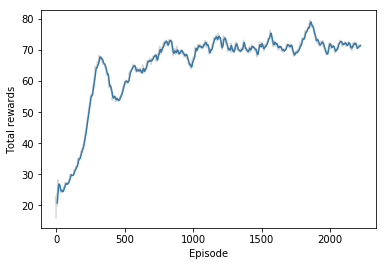

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

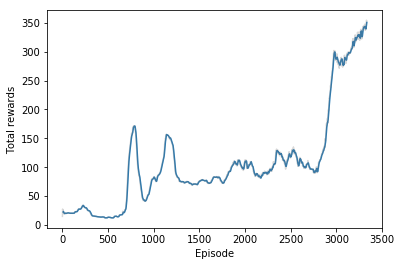

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

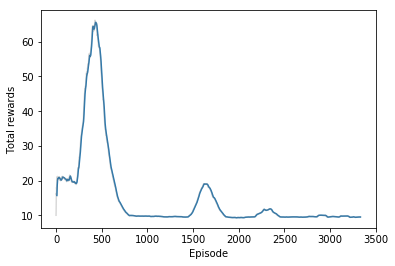

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

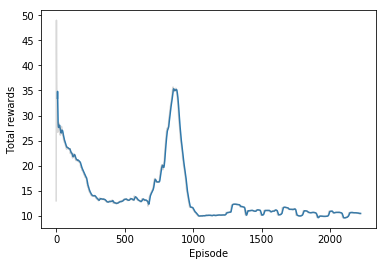

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

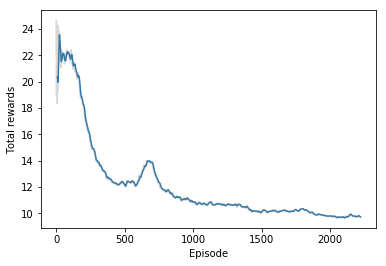

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

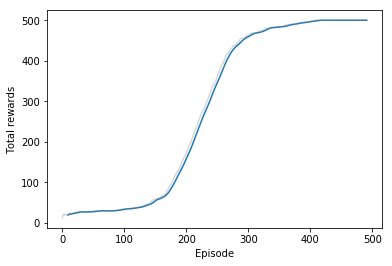

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

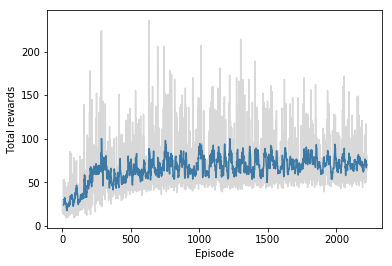

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

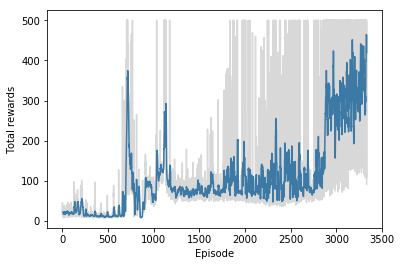

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

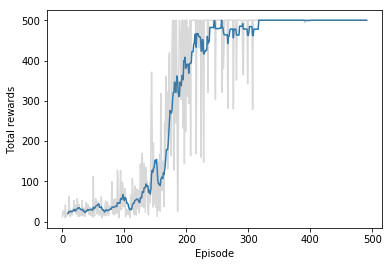

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.